In [1]:
wiki = read.csv("wiki.csv", stringsAsFactors = FALSE)

In [2]:
wiki$Vandal = as.factor(wiki$Vandal)

In [3]:
summary(wiki)

      X.1             X        Vandal       Minor           Loggedin     
 Min.   :   1   Min.   :   1   0:2061   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:1001   1st Qu.:1184   1:1815   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :2016   Median :2318            Median :0.0000   Median :1.0000  
 Mean   :2040   Mean   :2322            Mean   :0.2853   Mean   :0.6659  
 3rd Qu.:3069   3rd Qu.:3467            3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :4135   Max.   :4639            Max.   :1.0000   Max.   :1.0000  
    Added             Removed         
 Length:3876        Length:3876       
 Class :character   Class :character  
 Mode  :character   Mode  :character  
                                      
                                      
                                      

In [4]:
library(tm)
library(SnowballC)

Loading required package: NLP


In [5]:
length(stopwords("english")) 

[1] 174

In [6]:
corpusAdded = VCorpus(VectorSource(wiki$Added))
corpusAdded = tm_map(corpusAdded, removeWords, stopwords("english"))
corpusAdded = tm_map(corpusAdded, stemDocument)
dtmAdded = DocumentTermMatrix(corpusAdded)

In [9]:
dtmAdded

<<DocumentTermMatrix (documents: 3876, terms: 6675)>>
Non-/sparse entries: 15368/25856932
Sparsity           : 100%
Maximal term length: 784
Weighting          : term frequency (tf)

In [10]:
sparseAdded = removeSparseTerms(dtmAdded, 0.997)

In [11]:
sparseAdded

<<DocumentTermMatrix (documents: 3876, terms: 166)>>
Non-/sparse entries: 2681/640735
Sparsity           : 100%
Maximal term length: 28
Weighting          : term frequency (tf)

In [13]:
wordsAdded = as.data.frame(as.matrix(sparseAdded))
colnames(wordsAdded) = paste("A", colnames(wordsAdded))

In [15]:
corpusRemoved = VCorpus(VectorSource(wiki$Removed))
corpusRemoved = tm_map(corpusRemoved, removeWords, stopwords("english"))
corpusRemoved = tm_map(corpusRemoved, stemDocument)
dtmRemoved = DocumentTermMatrix(corpusRemoved)
sparseRemoved = removeSparseTerms(dtmRemoved, 0.997)
wordsRemoved = as.data.frame(as.matrix(sparseRemoved))
colnames(wordsRemoved) = paste("R", colnames(wordsRemoved))

In [17]:
ncol(wordsRemoved)

[1] 162

In [18]:
wikiWords = cbind(wordsAdded, wordsRemoved)

In [23]:
wikiWords$Vandal = wiki$Vandal

In [24]:
library(caTools)
set.seed(123)
split = sample.split(wikiWords$Vandal, SplitRatio = .7)
trainSparse = subset(wikiWords, split==TRUE)
testSparse = subset(wikiWords, split==FALSE)

In [26]:
table(testSparse$Vandal)


  0   1 
618 545 

In [28]:
618 / nrow(testSparse)

[1] 0.5313844

In [29]:
library(rpart)
CART = rpart(Vandal ~ ., data = trainSparse, method = "class")
CARTPredict = predict(CART, newdata = testSparse, type = "class")
table(CARTPredict, testSparse$Vandal)

           
CARTPredict   0   1
          0 618 533
          1   0  12

In [30]:
(618 + 12) / nrow(testSparse)

[1] 0.5417025

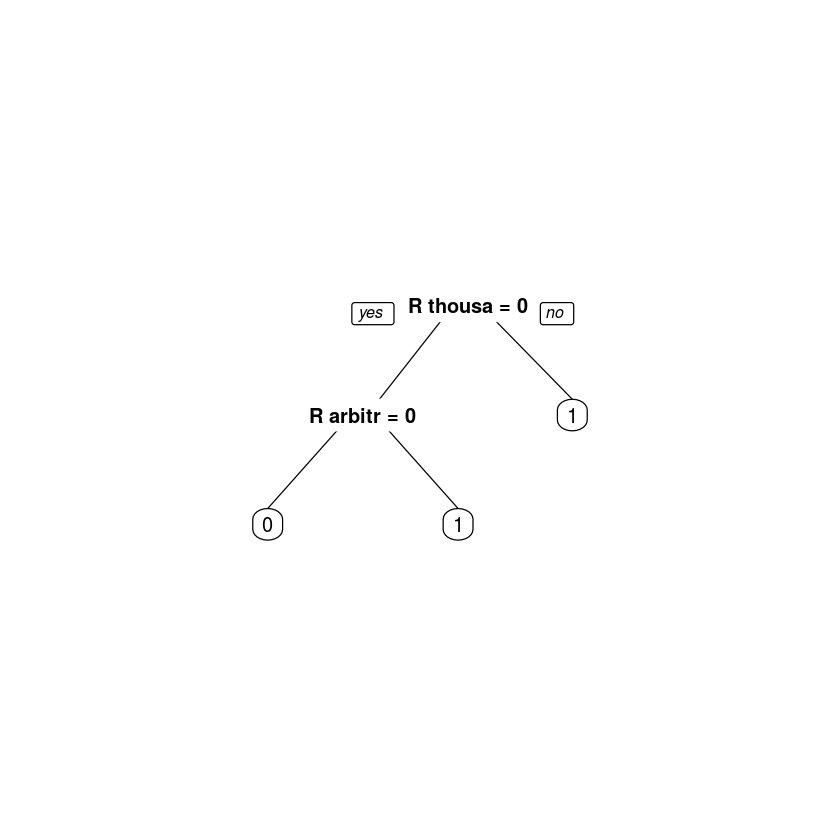

In [31]:
library(rpart.plot)
prp(CART)

In [32]:
wikiWords2 = wikiWords
wikiWords2$HTTP = ifelse(grepl("http",wiki$Added,fixed=TRUE), 1, 0)
table(wikiWords2$HTTP)


   0    1 
3659  217 

In [34]:
wikiTrain2 = subset(wikiWords2, split==TRUE)
wikiTest2 = subset(wikiWords2, split==FALSE)

In [35]:
CART = rpart(Vandal ~ ., data = wikiTrain2, method = "class")
CARTPredict = predict(CART, newdata = wikiTest2, type = "class")
table(CARTPredict, wikiTest2$Vandal)

           
CARTPredict   0   1
          0 609 488
          1   9  57

In [36]:
(609 + 57) / nrow(wikiTest2)

[1] 0.5726569

In [38]:
wikiWords2$NumWordsAdded = rowSums(as.matrix(dtmAdded))
wikiWords2$NumWordsRemoved = rowSums(as.matrix(dtmRemoved))

In [40]:
mean(wikiWords2$NumWordsAdded)

[1] 4.050052

In [41]:
wikiTrain2 = subset(wikiWords2, split==TRUE)
wikiTest2 = subset(wikiWords2, split==FALSE)
CART = rpart(Vandal ~ ., data = wikiTrain2, method = "class")
CARTPredict = predict(CART, newdata = wikiTest2, type = "class")
table(CARTPredict, wikiTest2$Vandal)

           
CARTPredict   0   1
          0 514 297
          1 104 248

In [42]:
(514 + 248) / nrow(wikiTest2)

[1] 0.6552021

In [43]:
wikiWords3 = wikiWords2
wikiWords3$Minor = wiki$Minor
wikiWords3$Loggedin = wiki$Loggedin
wikiTrain3 = subset(wikiWords3, split==TRUE)
wikiTest3 = subset(wikiWords3, split==FALSE)
CART = rpart(Vandal ~ ., data = wikiTrain3, method = "class")
CARTPredict = predict(CART, newdata = wikiTest3, type = "class")
table(CARTPredict, wikiTest3$Vandal)

           
CARTPredict   0   1
          0 595 304
          1  23 241

In [44]:
(595 + 241) / nrow(wikiTest3)

[1] 0.7188306

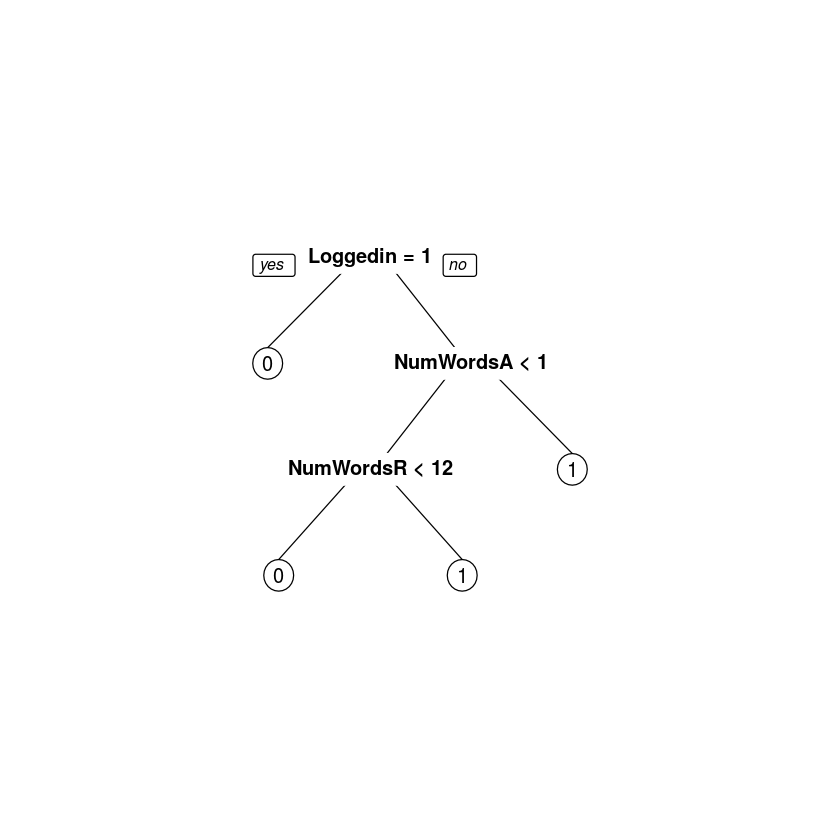

In [45]:
prp(CART)